# MAST Table Access Protocol PanSTARRS 1 DR2 Demo

<br> This tutorial demonstrates how to use astroquery to access PanSTARRS 1 Data Release 2 via a Virtual Observatory standard Table Access Protocol (TAP) service at MAST, and work with the resultant data. It relies on Python 3.

***
### Table of Contents

1. [AP Service Introduction](#TAP-Service-Introduction)
2. [Imports](#Imports)
3. [Useful Functions](#Useful-Functions)
3. [Connecting, Finding, and Displaying Table Information](#Connecting,-Finding,-and-Displaying-Table-Information)
    - [Connecting to a TAP Service](#Connecting-to-a-TAP-Service)
    - [Querying for Table Schema Information](#Querying-for-Table-Schema-Information)
    - [Querying for Data](#Querying-for-Data)
    - [Use Case: Plotting a light curve for the most variable object in a field](#Use-Case:-Plotting-a-light-curve-for-the-most-variable-object-in-a-field)
    - [Use Case: Create a color magnitude diagram for the Small Magellanic Cloud](#Use-Case:-Create-a-color-magnitude-diagram-for-the-Small-Magellanic-Cloud) <br><br>
4. [Additional Resources](#Additional-Resources)
5. [About This Notebook](#About-this-Notebook)
***

## TAP Service Introduction

Table Access Protocol (TAP) services allow more direct and flexible access to astronomical data than the simpler types of IVOA standard data services. Queries are built with the SQL-like Astronomical Data Query Language (ADQL), and can include geographic / spatial queries as well as filtering on other characteristics of the data. This also allows the user fine-grained control over the returned columns, unlike the fixed set of coumns retunred from cone, image, and spectral services.

For this example, we'll be using the astroquery TAP/TAP+ client, which was developed by the ESAC Space Data Centre for working with the GAIA catalog, but is interoperable with other valid TAP services, including those at MAST. As an astroquery project, TAP+ documentation is available at ReadTheDocs: http://astroquery.readthedocs.io/en/latest/utils/tap.html

We'll be using TAP+ to call the TAP service at MAST serving PanSTARRS 1 Data Release 2, now with individual detection information. The schema is described within the service, and we'll show how to inspect it. The schema is also the same as the one available via the CasJobs interface, with an additional view added for the most common positional queries. CasJobs has its own copy of the schema documentation, which can be accessed through its own site: http://mastweb.stsci.edu/ps1casjobs/



***
## Imports

In [80]:
# Use the astroquery TapPlus library as our client to the data service.
from astroquery.utils.tap.core import TapPlus

## For handling ordinary astropy Tables in responses
from astropy.table import Table

# For displaying and manipulating some types of results
%matplotlib inline
import requests
import astropy
import numpy as np
import pylab
import time
import json
from matplotlib import pyplot as plt

#for calling the object name resolver. Note these are Python 3 dependencies
import sys
import http.client as httplib 
from urllib.parse import quote as urlencode
from urllib.request import urlretrieve

# To allow display tweaks for wider response tables
from IPython.core.display import display
from IPython.core.display import HTML

ModuleNotFoundError: No module named '_curses'

***
## Useful Functions
Resolve names using [MAST query](https://mast.stsci.edu/api/v0/MastApiTutorial.html).

In [38]:
def mastQuery(request):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns head,content where head is the response HTTP headers, and content is the returned data"""
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    headers,resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

***
## Connecting to a TAP Service

The TapPlus library is able to connect to any TAP service, given the "base" URL as noted in metadata registry resources describing the service. This is the URL for the PanSTARRS 1 DR2 TAP service.

In [39]:
TAP_service = TapPlus(url="http://vao.stsci.edu/PS1DR2/tapservice.aspx")

Created TAP+ (v1.0.1) - Connection:
	Host: vao.stsci.edu
	Use HTTPS: False
	Port: 80
	SSL Port: 443


# Use Cases

## Simple positional query

This searches the mean object catalog for objects within 50 arcsec of M87 (RA=187.706, Dec=12.391 in degrees). The `fGetNearbyObjEq` function returns a list of object IDs, and the subsequent joins extract information from the [ObjectThin](https://outerspace.stsci.edu/x/W4Oc) table (which has information on object positions and the number of available measurements) and the [MeanObject](https://outerspace.stsci.edu/x/WYOc) table (which has information on photometry averaged over the multiple epochs of observation).

Note that the results are restricted to objects with `nDetections>1`, where `nDetections` is the total number of times the object was detected on the single-epoch images in any filter at any time.  Objects with `nDetections=1` tend to be  artifacts, so this is a quick way to eliminate most spurious objects from the catalog.

This query runs in TAP's asynchronous mode, which is a queued batch mode with some overhead and longer timeouts, useful for big catalogs like PanSTARRS. It may not be necessary for all queries to PS1 DR2, but the TAP+ client can automatically handle the additional processing required over synchronous mode.

In [44]:
job = TAP_service.launch_job_async("""
SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',187.706,12.391,.2))=1
AND nDetections > 1
  """)
TAP_results = job.get_results()
TAP_results

Query finished.


objID,RAMean,DecMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32
123061878291370064,187.82911445,12.54958617,3,0,0,1,1,1,-999.0,-999.0,21.8443,21.3244,20.0731
123071876051171575,187.60517146,12.55918313,39,8,10,8,7,6,21.5882,20.8265,20.5116,20.2779,19.8824
123071876084162495,187.60847055,12.56008291,30,9,8,8,5,0,21.7058,21.3354,21.0546,20.9275,-999.0
123071876093714495,187.60949233,12.56165023,57,6,12,12,12,15,22.0594,20.4839,19.7912,19.6981,19.2784
123071876178704897,187.61795425,12.56199748,5,0,3,2,0,0,-999.0,21.7051,21.7451,-999.0,-999.0
123071876268012463,187.62690405,12.55995063,5,1,1,3,0,0,22.1989,21.7308,21.8344,-999.0,-999.0
123071876308100672,187.63080928,12.55850985,53,7,10,10,10,16,21.3162,20.0941,19.7004,19.6551,19.434
123071876329671800,187.63296955,12.55940447,3,0,2,1,0,0,-999.0,21.6726,21.3181,-999.0,-999.0
123071876374472263,187.63738364,12.55959236,2,0,1,0,1,0,-999.0,21.2044,-999.0,17.5929,-999.0


## Get DR2 light curve for RR Lyrae star KQ UMa

This time we start with the object name, use the MAST name resolver (which relies on Simbad and NED) to convert the name to RA and Dec, and then query the PS1 DR2 mean object catalog at that position.  Then we run a spatial query to TAP using those coordinates.

In [45]:
objname = 'KQ UMa'
ra, dec = resolve(objname)
radius = 1.0/60.0 # radius = 1 arcsec

query = """
SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',{},{},{}))=1
AND nDetections > 1
""".format(ra,dec,radius)
print(query)

job = TAP_service.launch_job_async(query)
TAP_results = job.get_results()
TAP_results


SELECT objID, RAMean, DecMean, nDetections, ng, nr, ni, nz, ny, gMeanPSFMag, rMeanPSFMag, iMeanPSFMag, zMeanPSFMag, yMeanPSFMag
FROM dbo.MeanObjectView
WHERE
CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',139.3344625554179,68.6350884268329,0.016666666666666666))=1
AND nDetections > 1

Query finished.


objID,RAMean,DecMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32
190341393098886808,139.31005798,68.62167398,2,0,0,2,0,0,-999.0,-999.0,20.9007,-999.0,-999.0
190351393167379829,139.31684077,68.6325315,76,10,12,25,13,16,19.4137,18.1327,17.3319,16.9505,16.7579
190351393218782091,139.3221462,68.62611891,8,2,2,2,1,1,21.7947,21.6335,21.6634,21.1578,17.9726
190351393310872072,139.3310196,68.62606374,2,0,0,2,0,0,-999.0,-999.0,21.704,-999.0,-999.0
190351393338202415,139.33360654,68.62651092,2,0,0,2,0,0,-999.0,-999.0,21.3409,-999.0,-999.0
190351393399303775,139.33979726,68.62757712,2,0,0,2,0,0,-999.0,-999.0,20.6871,-999.0,-999.0
190351393441745113,139.34450814,68.62863736,2,0,0,2,0,0,-999.0,-999.0,20.8253,-999.0,-999.0
190351393503746503,139.35070447,68.62975839,2,0,0,2,0,0,-999.0,-999.0,20.7665,-999.0,-999.0
190351393585621382,139.35856069,68.62567905,2,0,2,0,0,0,-999.0,20.5799,-999.0,-999.0,-999.0


### Get Detection Information

Extract all the objects with the same object ID from the [Detection](https://outerspace.stsci.edu/x/b4Oc) table, which contains all the individual measurements for this source. The results are joined to the [Filter](https://outerspace.stsci.edu/x/nIOc) table to convert the filter numbers to names.  The somewhat odd structure for the ADQL (with the inner query in parentheses) ensures that the select by `objID` occurs before the match to the `Filter` table.  If the query optimizer gets confused and does the join between `Detection` and `Filter` before selecting the subset of objects, the query is very slow!

In [51]:
#objid = TAP_results['objID'][0]
objid = 190361393344112894
query = """
SELECT
    objID, detectID, d.filterID as filterID, f.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
FROM( select * from Detection where objID={} ) d
NATURAL JOIN Filter f
ORDER BY filterID, obsTime
""".format(objid)
print(query)

job = TAP_service.launch_job_async(query)
detection_TAP_results = job.get_results()
detection_TAP_results


SELECT
    objID, detectID, d.filterID as filterID, f.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
FROM( select * from Detection where objID=190361393344112894 ) d
NATURAL JOIN Filter f
ORDER BY filterID, obsTime

Query finished.


objID,detectID,filterid,filterType,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3
int64,int64,uint8,object,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32
190361393344112894,153347716310000010,1,g,55634.477414,139.3345207,68.63503577,0.00826192,1.14074e-05,1.88185,1.76734,0.992916,0.00861705,1.14233e-05,102760517,128,124782656
190361393344112894,153348968310000008,1,g,55634.4899457,139.33448821,68.63506146,0.0077373,1.10268e-05,1.81031,1.60518,0.998461,0.00792172,1.09406e-05,102760517,128,124782656
190361393344112894,232228791560000017,1,g,56423.2881719,139.33449441,68.63503952,0.00335198,7.26745e-06,1.60204,1.45048,0.998589,0.00338658,7.2363e-06,102760517,128,108038208
190361393344112894,255559866370000015,1,g,56656.5989211,139.33444592,68.63504589,0.00372909,7.37688e-06,1.82831,1.68692,0.999191,0.00372163,7.52088e-06,102760517,128,124815424
190361393344112894,262040070370000016,1,g,56721.4009635,139.33445148,68.63504807,0.003576,7.22894e-06,1.60585,1.50396,0.998605,0.00359603,7.43463e-06,102760517,128,7374912
190361393344112894,262040708370000014,1,g,56721.4073411,139.33445304,68.63504406,0.00350554,7.14809e-06,1.62415,1.48827,0.999487,0.00359624,7.43434e-06,102760517,128,7374912
190361393344112894,264231864260000022,1,g,56743.3189045,139.3344431,68.63504497,0.00343867,7.81574e-06,1.53957,1.4761,0.999049,0.00361239,7.85237e-06,102760517,128,7374912
190361393344112894,264232516260000024,1,g,56743.3254198,139.33444512,68.63505285,0.00347403,7.87789e-06,1.52751,1.43325,0.999367,0.00360349,7.8686e-06,102760517,128,7374912
190361393344112894,153441340410000012,2,r,55635.4136426,139.33447173,68.6350534,0.00978758,1.10843e-05,1.67879,1.5653,0.998509,0.00990763,1.11231e-05,102760517,128,124815424


### Plot the light curves

The `psfFlux` values from the Detection table are converted from Janskys to AB magnitudes.  Measurements in the 5 different filters are plotted separately.

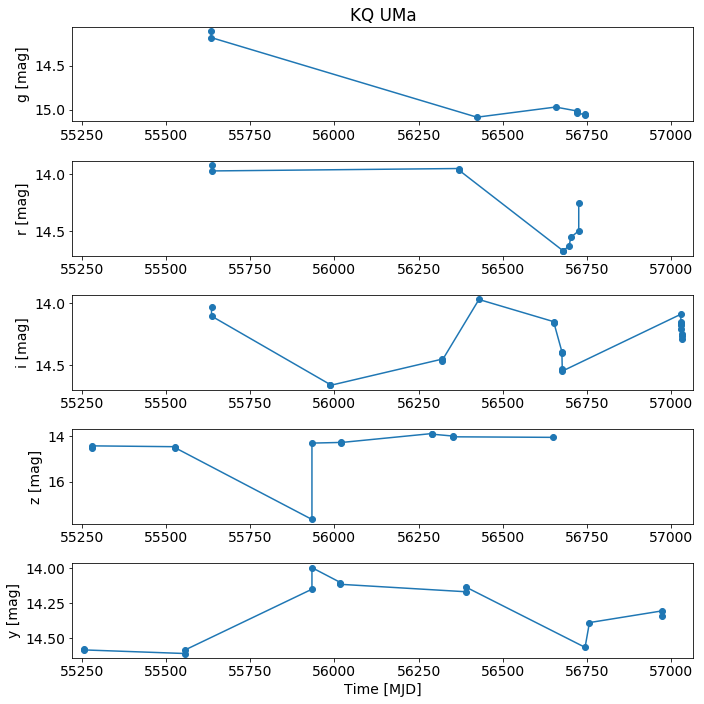

In [89]:
# convert flux in Jy to magnitudes
t = detection_TAP_results['obsTime']
mag = -2.5*np.log10(detection_TAP_results['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
#detection_TAP_results['filterType'] is a byte string, compare accordingly:
for i, filter in enumerate([b'g',b'r',b'i',b'z',b'y']):
    pylab.subplot(511+i)
    w = np.where(detection_TAP_results['filterType']==filter)    
    pylab.plot(t[w],mag[w],'-o')
    pylab.ylabel(filter.decode('ascii')+' [mag]')
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

***
# Additional Resources


## Table Access Protocol 
* IVOA standard for RESTful web service access to tabular data
* http://www.ivoa.net/documents/TAP/

## Hubble Source Catalog v3
* Catalog created at MAST by combining the tens of thousands of visit-based source lists in the Hubble Legacy Archive (HLA) into a single master catalog. 
* https://archive.stsci.edu/hst/hsc/

## Astronomical Query Data Language (2.0)
* IVOA standard for querying astronomical data in tabular format, with geometric search support
* http://www.ivoa.net/documents/latest/ADQL.html

## TapPlus 
* Module created by ESAC Space Data Centre
* http://astroquery.readthedocs.io/en/latest/utils/tap.html

***

## About this Notebook
**Authors:** Rick White & Theresa Dower, STScI Archive Scientist & Software Engineer
**Updated On:** 11/23/2018

***

<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 